# CFAR 10

In [1]:
!pip show tensorflow
!pip show keras

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\ghost\anaconda3\envs\daks\lib\site-packages
Requires: tensorflow-intel
Required-by: retina-face
Name: keras
Version: 2.13.1
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\ghost\anaconda3\envs\daks\lib\site-packages
Requires: 
Required-by: tensorflow-intel


# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.utils.multiclass import unique_labels

import os

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
import tensorflow as tf
from keras.applications import ResNet50


'Lastly import the final layers that will be added on top of the base model'
from tensorflow.keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,UpSampling2D,GlobalAveragePooling2D,Conv2D

# Import dataset


In [4]:
from keras.datasets import cifar10

In [5]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

# Print the dimensions of the datasets to make sure everything's good

In [6]:
print((x_train.shape,y_train.shape))
print((x_test.shape,y_test.shape))

((50000, 32, 32, 3), (50000, 1))
((10000, 32, 32, 3), (10000, 1))


In [7]:
x_train=x_train/255
x_test=x_test/255

## Steps for building a transfer learning model:

* Build the model (Base Model + Flatten + Dense)

* Check model summary

* Initialize Batch Size,Number of Epochs
Compile model

* Fit the model 

* Evaluate the model on test data

# Build the model

In [8]:
'''For the 2nd base model we will use Resnet 50 and compare the
 performance against the previous one.'''
base_model = ResNet50(include_top=False,weights='imagenet',input_shape=(32, 32, 3))


In [9]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [11]:
# for index,layer in enumerate(base_model.layers):
#     if index%2==0:
#         layer.trainable = False
#     else:
#         layer.trainable = True
#     # print(layer)

In [13]:
# # for layer in base_model.layers:
# #     layer.trainable=False

# for layer in base_model.layers[150:175]:
#     layer.trainable=True

In [16]:
for layer in base_model.layers:
    layer.trainable = True

# Set Model

In [17]:
#Since we have already defined Resnet50 as base_model_2, let us build the sequential model.

model = Sequential()

model.add(Conv2D(filters=3, kernel_size=(3,3),input_shape = (32,32,3), activation='relu',padding="same"))

# model.add(UpSampling2D(size=(7, 7)))

model.add(base_model)

model.add(GlobalAveragePooling2D()) # equivalent to model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 3)         84        
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                      

# Compile the model 


In [15]:

model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Early Stopping

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=3)

In [17]:
history = model.fit(x_train, y_train, batch_size=2, epochs=20, validation_split=0.2, callbacks=[early_stop])

MemoryError: Unable to allocate 469. MiB for an array with shape (40000, 32, 32, 3) and data type float32

In [40]:
metrics = pd.DataFrame(model.history.history)

# Metrics

<Axes: >

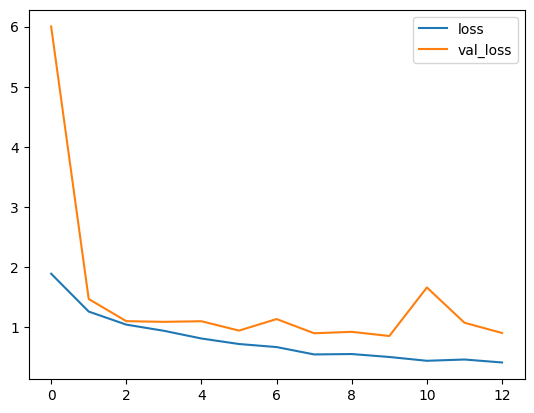

In [41]:
metrics[['loss', 'val_loss']].plot()

<Axes: >

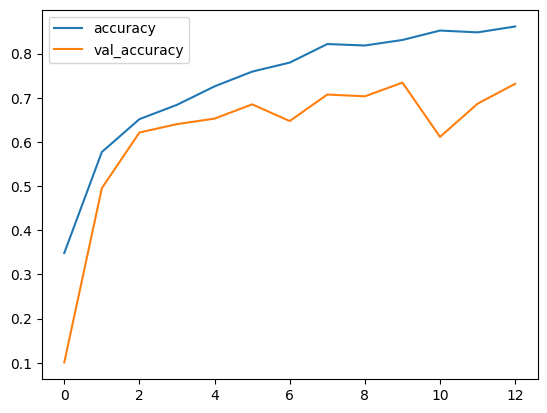

In [42]:
metrics[['accuracy', 'val_accuracy']].plot()

# Save Model and History

In [1]:
model.save('cfar10_resnet.h5')

In [ ]:
import pickle

with open('history_resnet.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Evaluate

In [48]:
prediction = model.predict(x_test)
predictions = [np.argmax(x, axis=0) for x in prediction]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [50]:
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.84      0.76      1000
           1       0.86      0.80      0.83      1000
           2       0.63      0.69      0.66      1000
           3       0.55      0.57      0.56      1000
           4       0.72      0.66      0.69      1000
           5       0.62      0.68      0.65      1000
           6       0.82      0.74      0.77      1000
           7       0.79      0.76      0.77      1000
           8       0.83      0.81      0.82      1000
           9       0.88      0.76      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



# Analyze

In [52]:
import seaborn as sns

In [53]:
fig_class=[ "airplane", "automobile","bird","cat","deer", "dog","frog","horse","ship","truck"]

<Axes: >

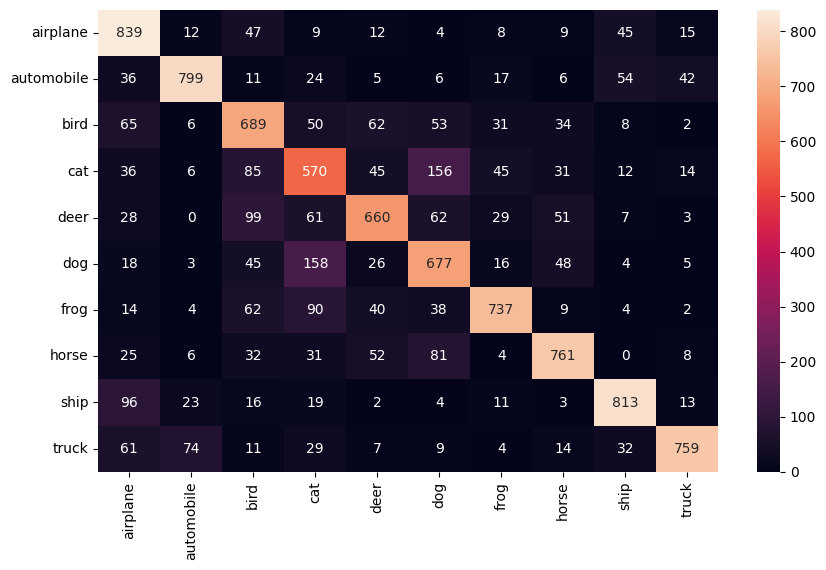

In [54]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt='d',xticklabels=fig_class,yticklabels=fig_class)